In [1]:
import torch
import numpy as np
from torch import optim
import os
import matplotlib.pyplot as plt
import seaborn

In [2]:
#from datareader import DLEMDataset
#from models.encodetocontact_forked import DLEM
#import util
import dlem.util as util
from dlem import load_reader, load_model

In [3]:
import dlem

In [4]:
def return_pred_diag(model, patchs, tracks):
    patchs = torch.from_numpy(patchs)
    tracks = torch.from_numpy(tracks)
    init_diag = torch.from_numpy(np.ones((tracks.shape[0], tracks.shape[2]), dtype=np.float32))
    return model.contact_map_prediction(tracks, init_diag)

In [5]:
def return_pred_param(model, patch, tracks):
    patch = torch.from_numpy(patch)
    tracks = torch.from_numpy(tracks)
    init_diag = torch.from_numpy(np.ones((tracks.shape[0], tracks.shape[2]), dtype=np.float32))
    def convert_diags(diags):
        return util.convert_diags_to_full_contact(
                    diags,
                    model.start_diag,
                    model.stop_diag
               )

    preds = model.contact_map_prediction(tracks, init_diag)
    preds = [convert_diags(p) for p in preds]

    p_l, p_r = model.return_parameters(tracks)
    return preds, p_l, p_r


In [6]:
!ls ../.data/dlem_training

2_per_route	       5_per_route	features.dat   trained_forked_model
3_per_route_diffusion  contactmaps.dat	meta.json      trained_forked_model_1
4_per_route	       deneme		sequences.bed  trained_models


In [7]:
BATCH_SIZE = 64
DATA_FOLDER = ".data/dlem_training"
#DATA_FOLDER = "../.data/dlem_training"
TEST_FOLD = 'fold4'
VAL_FOLD = 'fold5'
LEARNING_RATE = 0.001
PATIENCE = 200
NUM_EPOCH = 100
NUMBER_OF_CHANNELS_PER_ROUTE = 3
#MODEL_FOLDER = f"{NUMBER_OF_CHANNELS_PER_ROUTE}_per_route_res_1000"
MODEL_FOLDER = "without_ctcf"

In [8]:
!ls .data/dlem_training/without_ctcf

best_correlation.pt  best_loss.pt


In [9]:
dev = torch.device("cpu")

In [10]:
data = load_reader("datareader")(DATA_FOLDER, [1,2,3])

data_test = torch.utils.data.Subset(data, np.where(data.data_folds == TEST_FOLD)[0])

In [11]:
data.args

{'RES': 10000,
 'PATCH_SIZE': 120,
 'BW_FILES': ['H1_CTCF_ENCFF038RVZ.bigWig', 'H1_DNAse_ENCFF232GUZ.bigWig'],
 'SEQ_FEA_FILES': ['sequence_features_pos_10000.tsv',
  'sequence_features_neg_10000.tsv'],
 'START_DIAG': 3,
 'STOP_DIAG': 80,
 'PATCH_DIM': 120,
 'PATCH_LEN': 6083,
 'FEA_DIM': 4,
 'REGION_FILE': 'sequences.bed',
 'COOLER_FILE': '4DNFI9GMP2J8.mcool',
 'SAMPLE_NUM': 5555}

In [12]:
data.stop_diag

80

In [13]:
model =load_model("encodetocontact_forked")(data.patch_dim,
             data.feature_dim,
             data.start_diag,
             data.stop_diag,
             channel_per_route=NUMBER_OF_CHANNELS_PER_ROUTE)

In [14]:
model.load_state_dict(
         torch.load(os.path.join(DATA_FOLDER, MODEL_FOLDER, "best_correlation.pt"))
)
model = model.to(dev).eval()

In [15]:
model

DLEM(
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv1d(3, 12, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(9, 9, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv1d(6, 6, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
  )
  (trans_convs): ModuleList(
    (0-3): 4 x Sequential(
      (0): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
  )
  (mixer): Sequential(
    (0): Conv1d(12, 2, kernel_size=(1,), stride=(1,))
    (1): Sigmoid()
  )
)

In [16]:
def plot_one_sample(patch, pred, p_l, p_r, scale, axes):
    util.plot_results(patch, pred,
                (p_l, p_r, np.ones_like(p_l)),
                ignore_i=data.start_diag, ignore_i_off=data.stop_diag,
                cmap="vlag", scale=scale, axes=axes)

def plot_multiple_samples(nrows, ncols, data, samples, model, scale=0.4):
    preds, p_l, p_r = return_pred_param(model,
                                        np.stack([data[i][0] for i in samples], axis=0),
                                        np.stack([data[i][1] for i in samples], axis=0))
    #patch_mat = [util.convert_diags_to_full_contact(patch, model.start_diag, model.stop_diag) for patch in samples[0]]
    patch_mat = [util.convert_diags_to_full_contact(data[i][0], model.start_diag, model.stop_diag) for i in samples]
    _, axes = plt.subplots(nrows=2*nrows, ncols=2*ncols, figsize=(ncols*12*scale, nrows*12*scale),
                                sharex='col',
                                sharey='row',
                                gridspec_kw={'wspace':0,
                                            'hspace':0,
                                            'height_ratios':[1, 5] * nrows,
                                            'width_ratios':[5, 1] * ncols})
    i = 0
    for r in range(nrows):
        for c in range(ncols):
            plot_one_sample(patch_mat[i], preds[i], p_l[i], p_r[i], scale, axes[2*r:2*(r+1), 2*c:2*(c+1)])
            i += 1

In [59]:
def return_track_pred(model, data):
    p_l_list = []
    p_r_list = []
    track_list = []
    for patch, track in data:
        _, p_l, p_r = return_pred_param(model, patch[np.newaxis], track[1:][np.newaxis])
        p_l_list.append(p_l)
        p_r_list.append(p_r)
        track_list.append(track)
    return p_l_list, p_r_list, track_list


In [61]:
data_track = load_reader("datareader")(DATA_FOLDER)

data_track_test = torch.utils.data.Subset(data_track, np.where(data_track.data_folds == TEST_FOLD)[0])

param_l_list, param_r_list, track_list = return_track_pred(model, data_track_test)

In [62]:
param_l_arr = np.concatenate(param_l_list,axis=1)
param_r_arr = np.concatenate(param_r_list,axis=1)
track_arr = np.concatenate(track_list,axis=1)

Text(0.5, 1.0, 'Without CTCF')

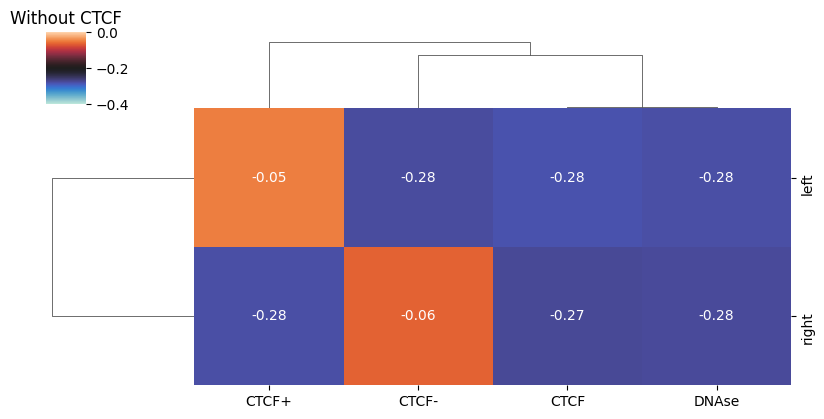

In [69]:
names = ["left", "right", "CTCF", "DNAse", "CTCF+", "CTCF-"]
seaborn.clustermap(np.corrcoef(np.concatenate([param_l_arr, param_r_arr, track_arr], axis=0))[:2,2:],
                   xticklabels=['CTCF', 'DNAse', 'CTCF+', 'CTCF-', 'left', 'right'],
                   yticklabels=['left', 'right'],
                   figsize=(8, 4),
                   annot=True,
                   fmt=".2f",
                   cmap="icefire",
                   vmax=0,
                   vmin=-0.4)
plt.title("Without CTCF")

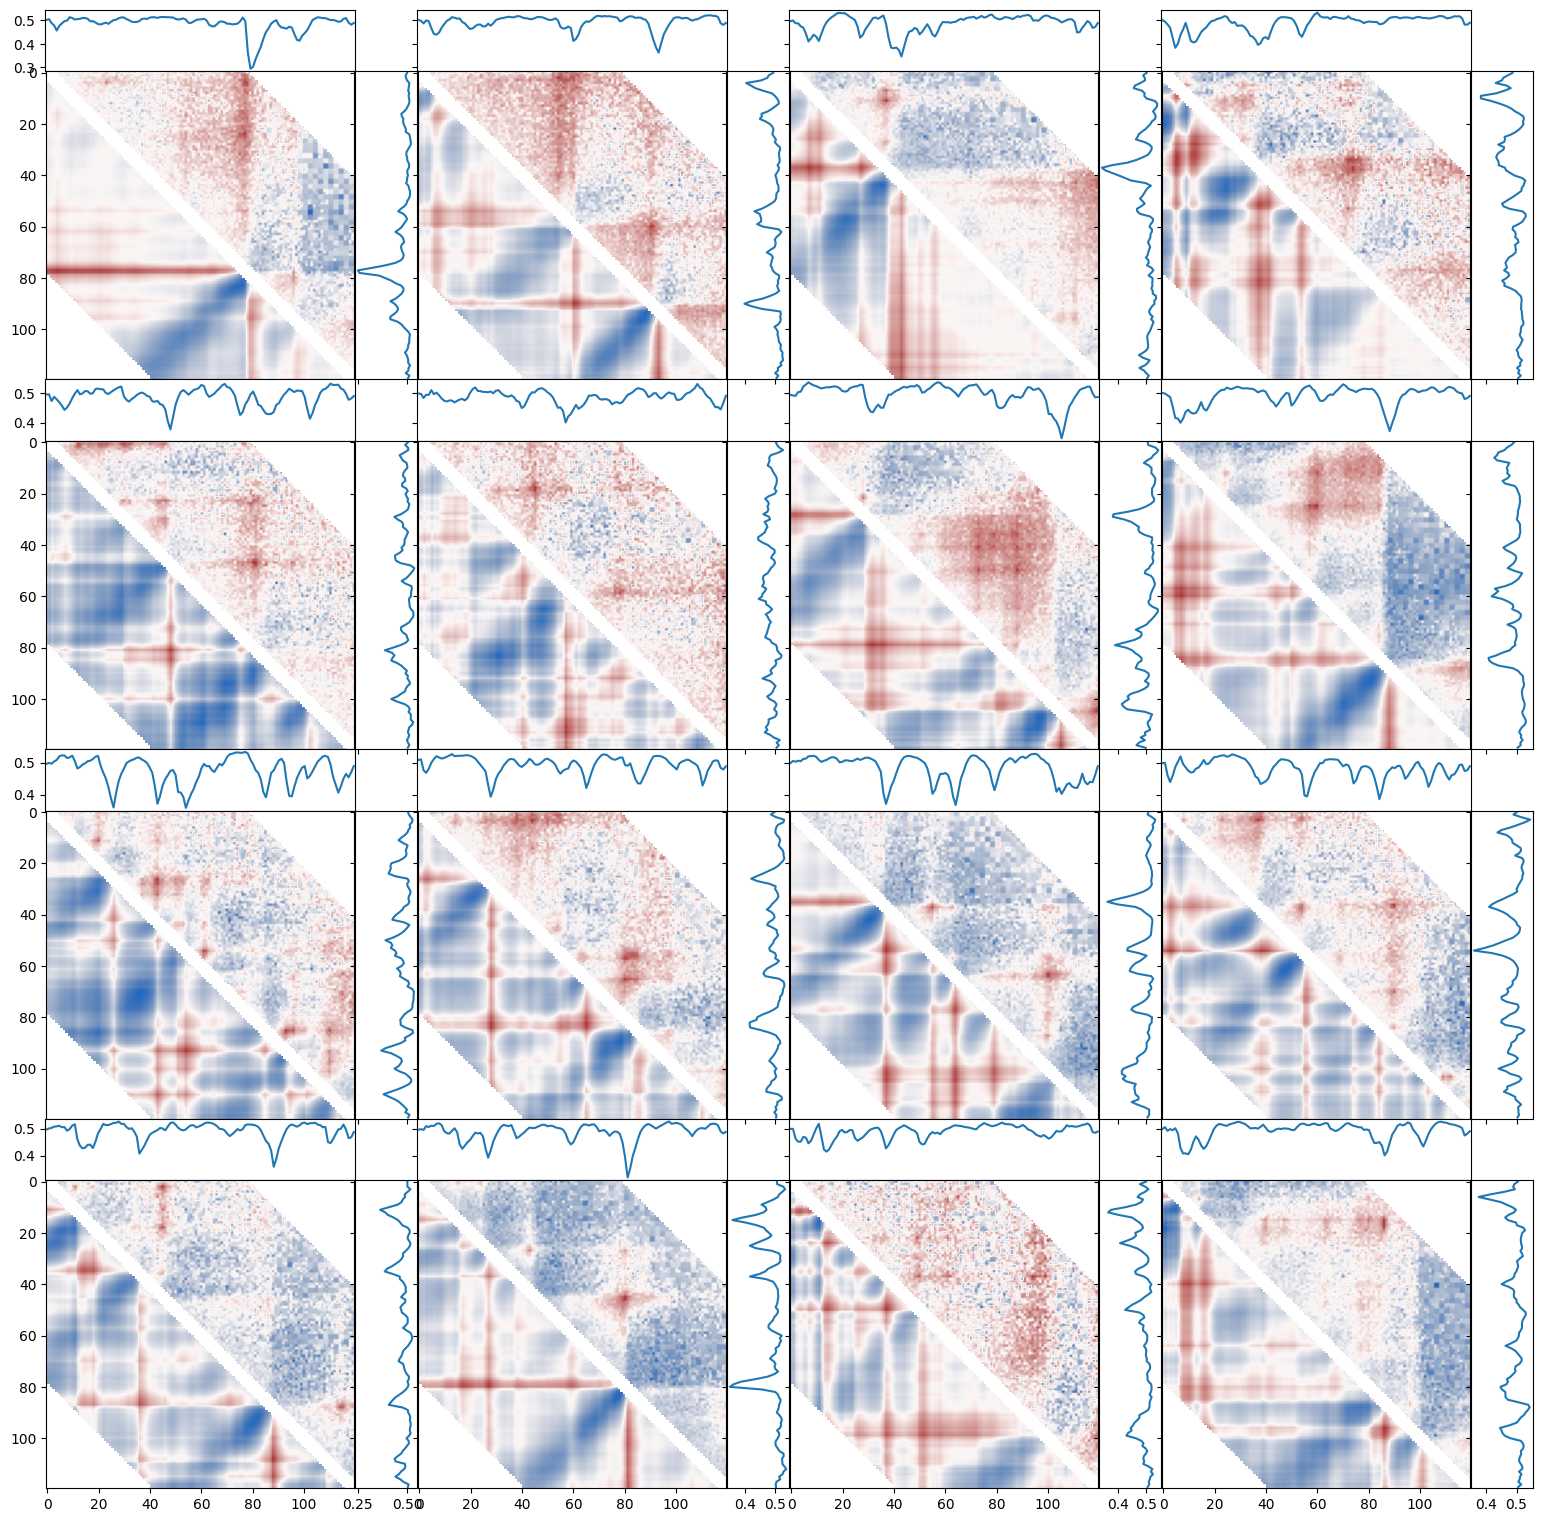

In [21]:
plot_multiple_samples(4,4,data_test,np.random.choice(range(len(data_test)), 16), model)

Cherry picking

In [39]:
corrs = []
for i in range(len(data_test)//10):
    patches = np.stack([data_test[i][0] for i in range(i*10,(i+1)*10)], axis=0)
    tracks = np.stack([data_test[i][1] for i in range(i*10,(i+1)*10)], axis=0)
    pred = return_pred_diag(model,
                            patches,
                            tracks).detach().cpu().numpy()
    corrs.append(np.diag(np.corrcoef(patches,pred)[:10,10:]))

In [44]:
corrs = np.concatenate(corrs)

In [45]:
len(corrs)

680

In [46]:
np.max(corrs)

0.7596612445049863

In [47]:
np.mean(corrs)

0.3621704114633887

In [48]:
np.median(corrs)

0.39046991883109905

In [90]:
np.median(corrs), np.mean(corrs), np.max(corrs), np.min(corrs)

(0.39046991883109905,
 0.3621704114633887,
 0.7596612445049863,
 -0.29535324688657905)

(array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ]),
 [Text(0, -1.0, '−1.00'),
  Text(0, -0.75, '−0.75'),
  Text(0, -0.5, '−0.50'),
  Text(0, -0.25, '−0.25'),
  Text(0, 0.0, '0.00'),
  Text(0, 0.25, '0.25'),
  Text(0, 0.5, '0.50'),
  Text(0, 0.75, '0.75'),
  Text(0, 1.0, '1.00')])

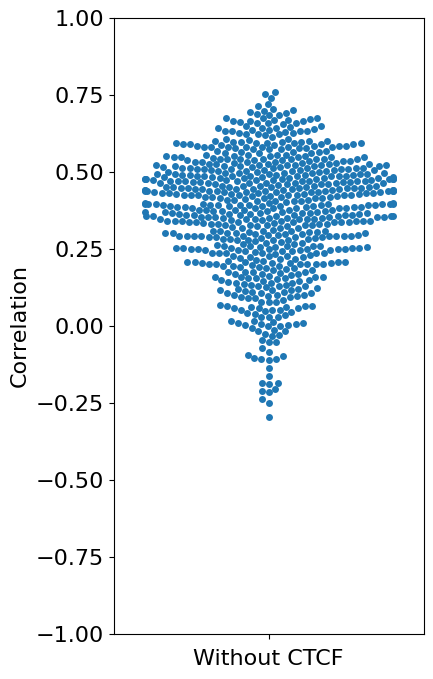

In [58]:
plt.figure(figsize=(4,8))
seaborn.swarmplot(y=corrs)
plt.ylabel("Correlation", fontsize=16)
plt.xlabel("Without CTCF", fontsize=16)
plt.ylim(-1, 1)
plt.yticks(fontsize=16)

In [50]:
len(data_test)

683

([<matplotlib.axis.YTick at 0x7e82090c3190>,
 [Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0')])

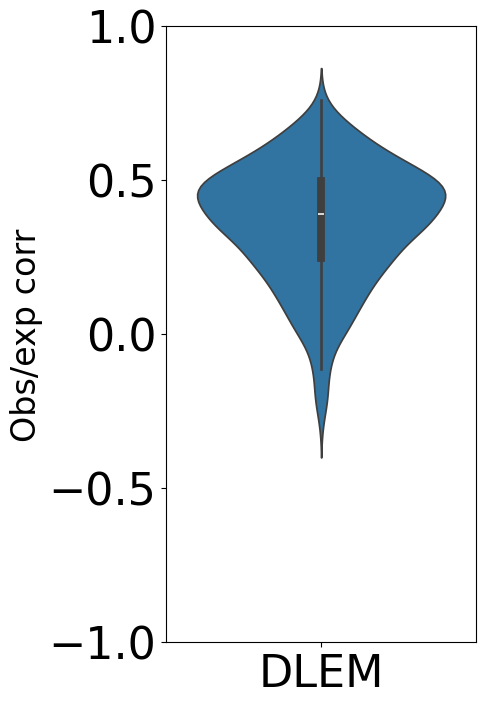

In [51]:
plt.figure(figsize=(4,8))
seaborn.violinplot(y=corrs)
plt.ylabel("Obs/exp corr", fontsize=24)
plt.xticks(ticks=[0], labels=["DLEM"], fontsize=32)
plt.ylim(-1, 1)
plt.yticks([-1, -0.5, 0, 0.5, 1], fontsize=32)

<Axes: >

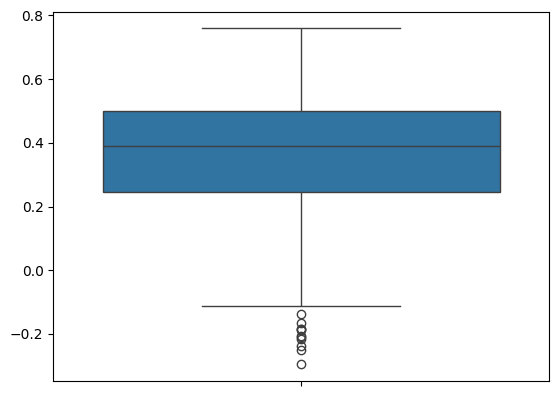

In [52]:
seaborn.boxplot(corrs)

In [53]:
np.quantile(corrs, 0.01)

-0.18532160713635348

In [54]:
np.sort(corrs[0>corrs])

array([-0.29535325, -0.25064191, -0.2387724 , -0.2166147 , -0.21095096,
       -0.20502497, -0.1888597 , -0.1843811 , -0.1843447 , -0.16405755,
       -0.1387899 , -0.1118096 , -0.10957502, -0.10745685, -0.10513796,
       -0.09891615, -0.0964158 , -0.08387055, -0.07352546, -0.0539056 ,
       -0.05283193, -0.0469895 , -0.03400187, -0.0310158 , -0.02644838,
       -0.0170194 , -0.01609252, -0.01233481, -0.0082817 , -0.00078894])

In [55]:
corrs[np.argsort(-corrs)[:16]]

array([0.75966124, 0.75133877, 0.74054954, 0.71994495, 0.71206074,
       0.70268025, 0.69986856, 0.69725979, 0.69484733, 0.69032658,
       0.68834876, 0.68407038, 0.68340079, 0.67477422, 0.67466481,
       0.67391695])

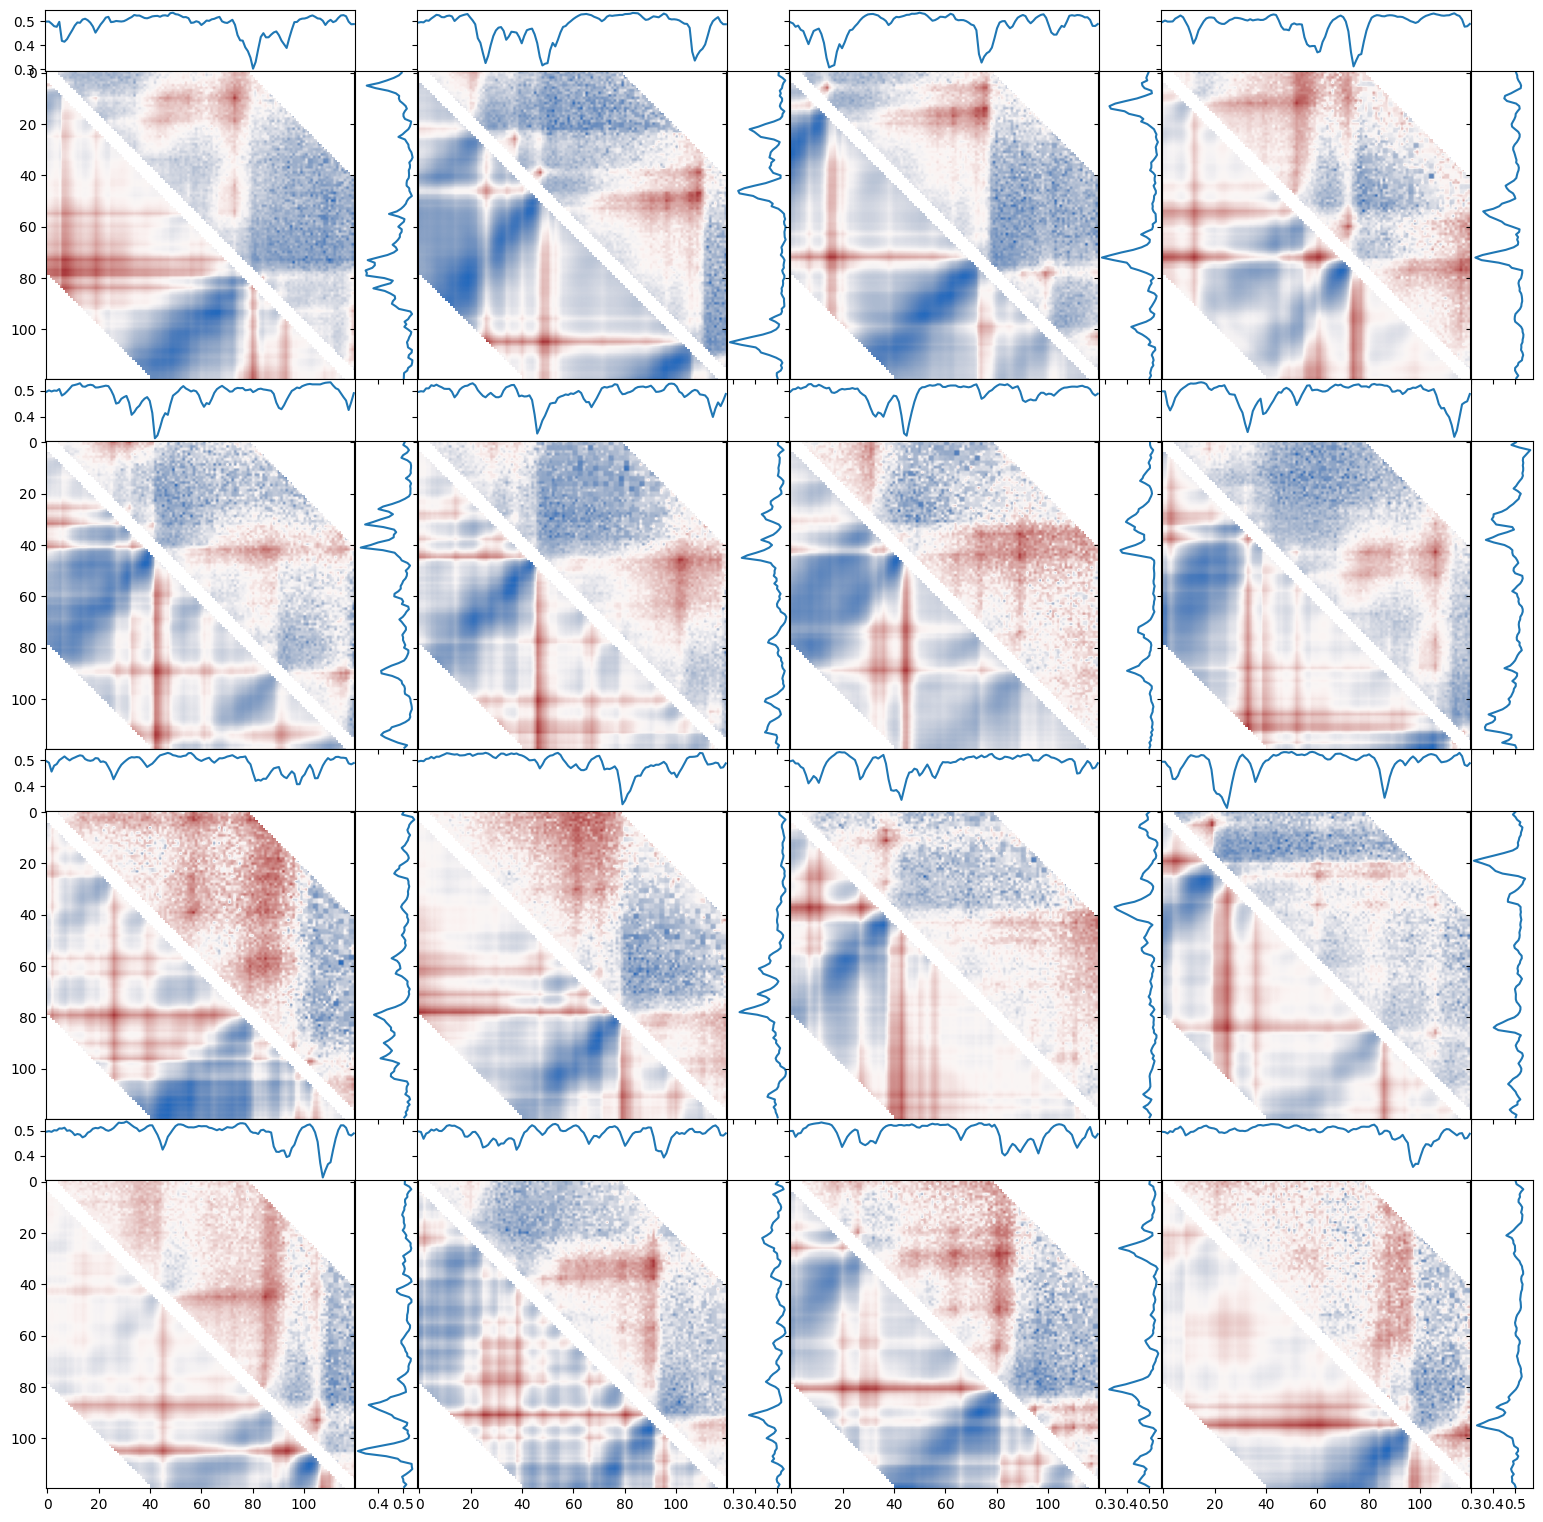

In [57]:
plot_multiple_samples(4,4,data_test,np.argsort(-corrs)[:16], model)

In [ ]:
corrs[np.argsort(corrs)[:16]]

array([-0.28683485, -0.23380565, -0.23289453, -0.19504743, -0.11890996,
       -0.11214005, -0.06748076, -0.06484969, -0.05762582, -0.03297301,
       -0.03090805, -0.02641434, -0.01986569, -0.00826928, -0.00531679,
       -0.00125462])

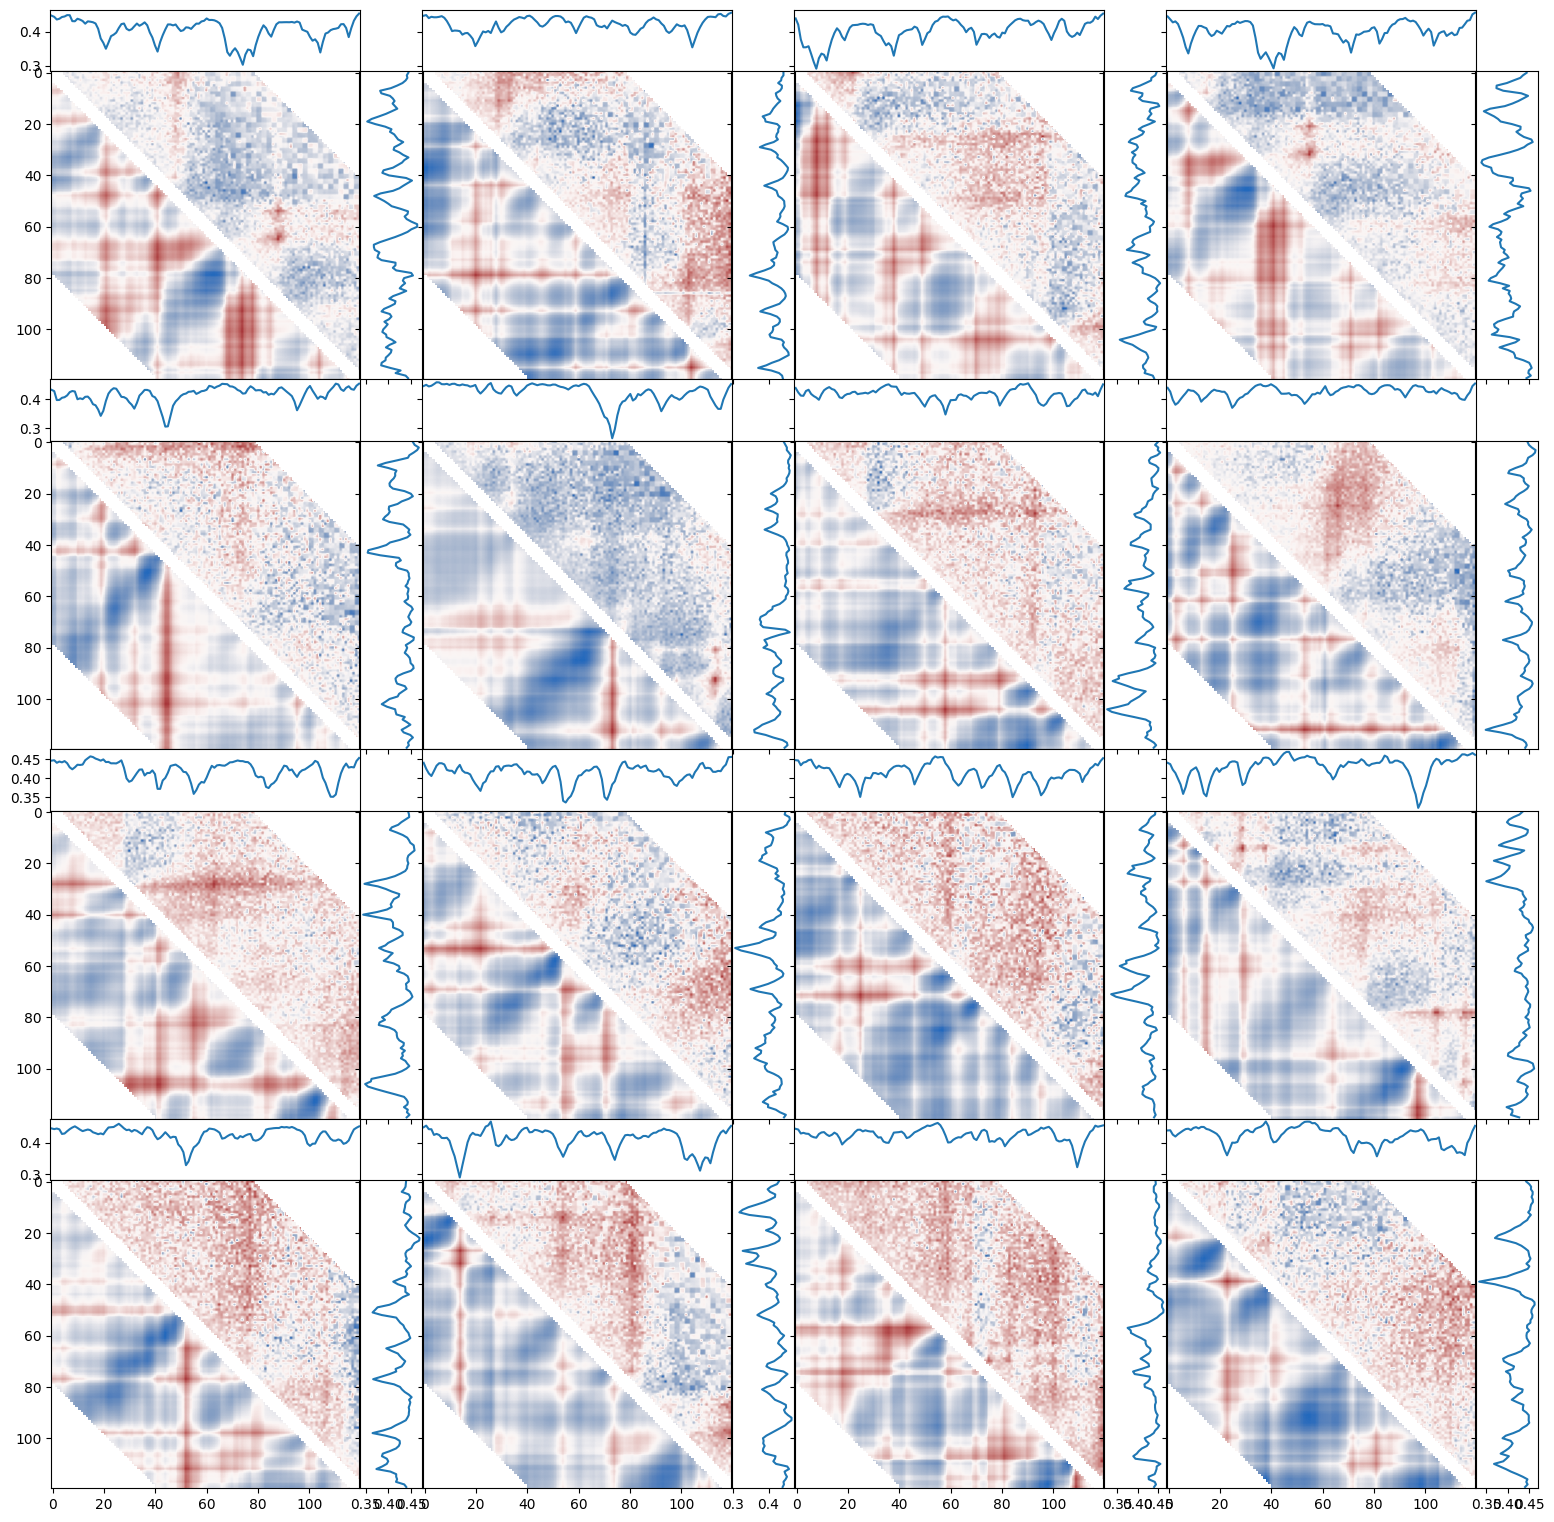

In [ ]:
plot_multiple_samples(4,4,data_test[np.argsort(corrs)[:16]], model)

In [78]:
discrepancy_w_ctcf = 328

In [79]:
corrs[discrepancy_w_ctcf]

0.4723840237377612

In [83]:
data_test[discrepancy_w_ctcf][0].shape

(6083,)

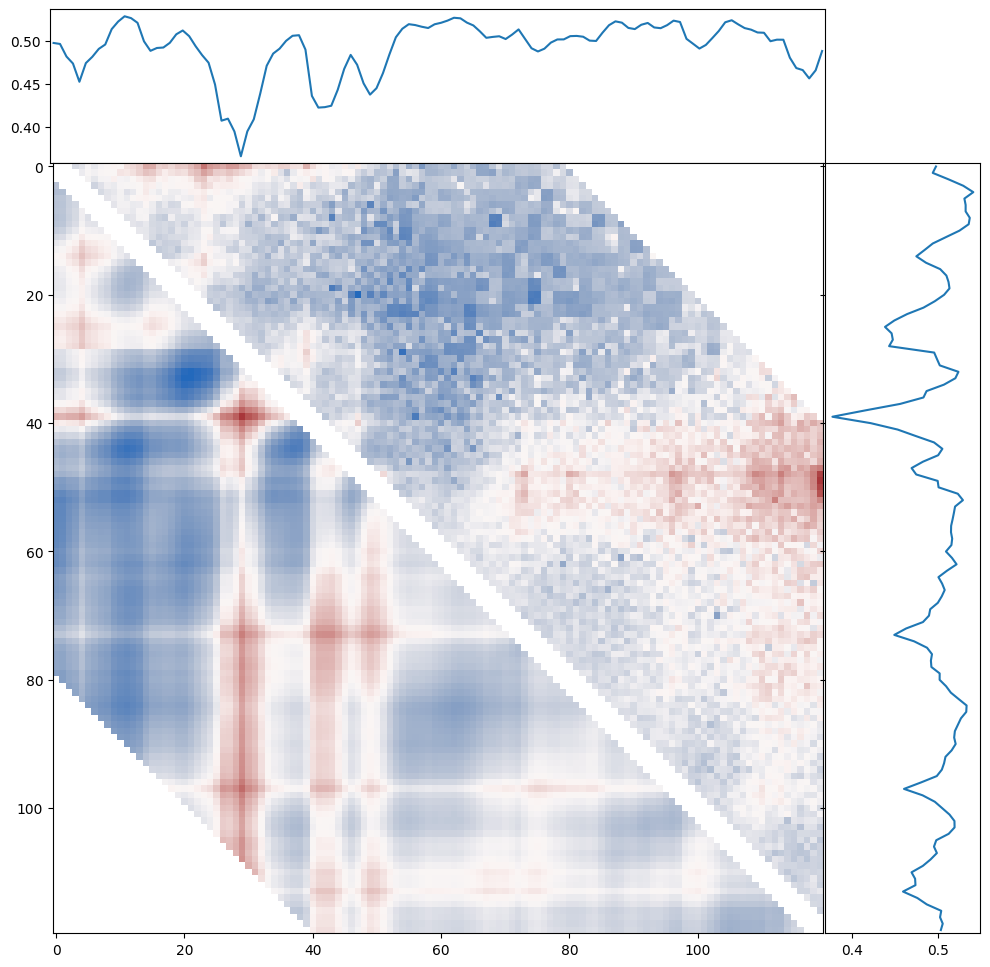

In [86]:
preds, p_l, p_r = return_pred_param(model,
                                    data_test[discrepancy_w_ctcf][0][np.newaxis],
                                    data_test[discrepancy_w_ctcf][1][np.newaxis])
patch_mat = util.convert_diags_to_full_contact(data_test[discrepancy_w_ctcf][0], model.start_diag, model.stop_diag)
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12),
                                sharex='col',
                                sharey='row',
                                gridspec_kw={'wspace':0,
                                            'hspace':0,
                                            'height_ratios':[1, 5],
                                            'width_ratios':[5, 1]})
plot_one_sample(patch_mat, preds[0], p_l[0], p_r[0], 1, axes)

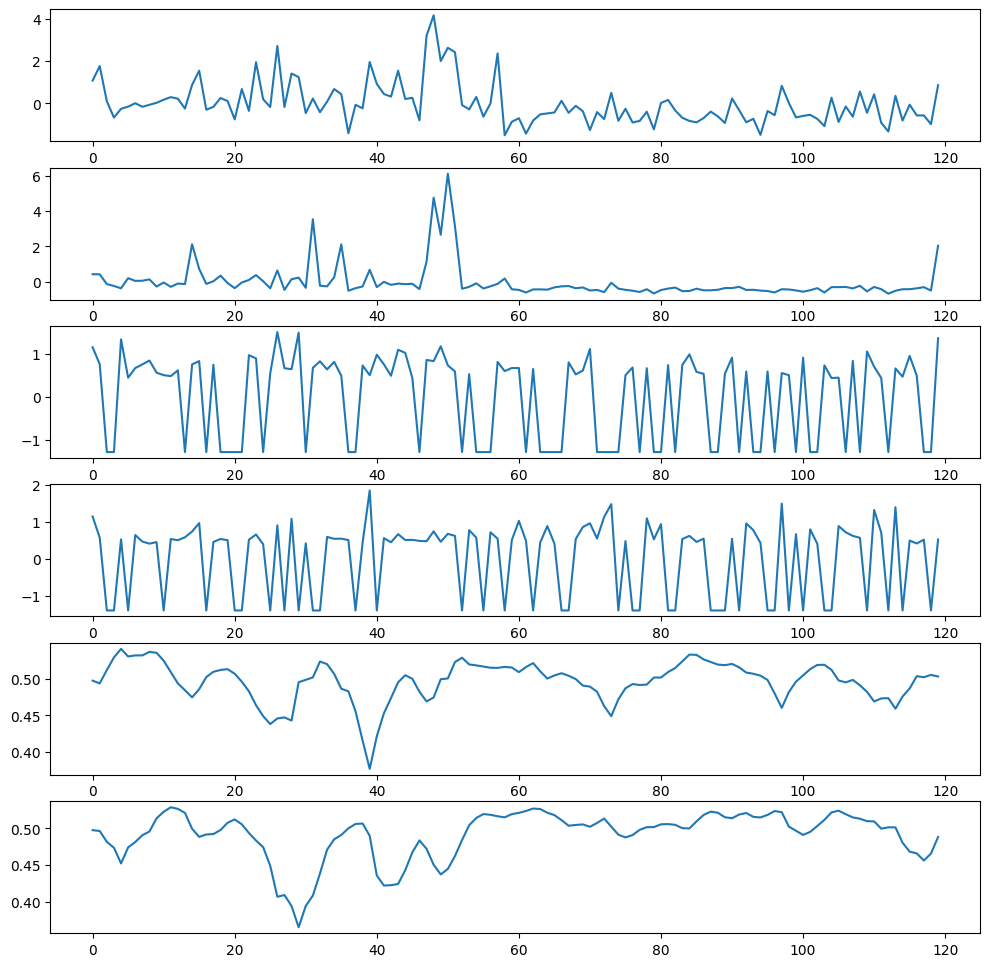

In [87]:
_, axes = plt.subplots(6, 1, figsize=(12, 12))
for ax, sig in zip(axes[:4], data_track_test[discrepancy_w_ctcf][1]):
    ax.plot(sig)
axes[4].plot(p_l[0])
axes[5].plot(p_r[0])

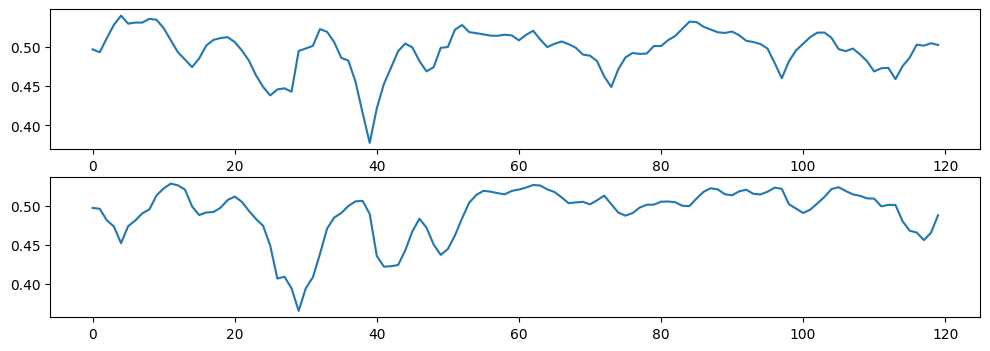

In [88]:
_, axes = plt.subplots(2, 1, figsize=(12, 4))
axes[0].plot(p_l[0])
axes[1].plot(p_r[0])

In [ ]:
samples = data_test[[np.argsort(-corrs)[3]]]
preds, p_l, p_r = return_pred_param(model, samples[0], samples[1])
patch_mat = [util.convert_diags_to_full_contact(patch, model.start_diag, model.stop_diag) for patch in samples[0]]

In [ ]:
!pwd

/data/src/loopextrusion_pytorch/dlem/examples


In [ ]:
np.save("data/patch_deep.npy", patch_mat[0])
np.save("data/encode_deep.npy", data_test[[np.argsort(-corrs)[3]][0]][1])

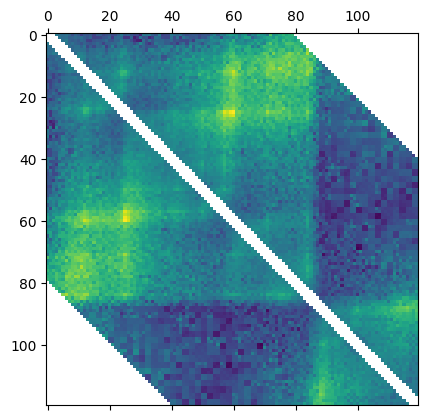

In [ ]:
plt.matshow(patch_mat[0])

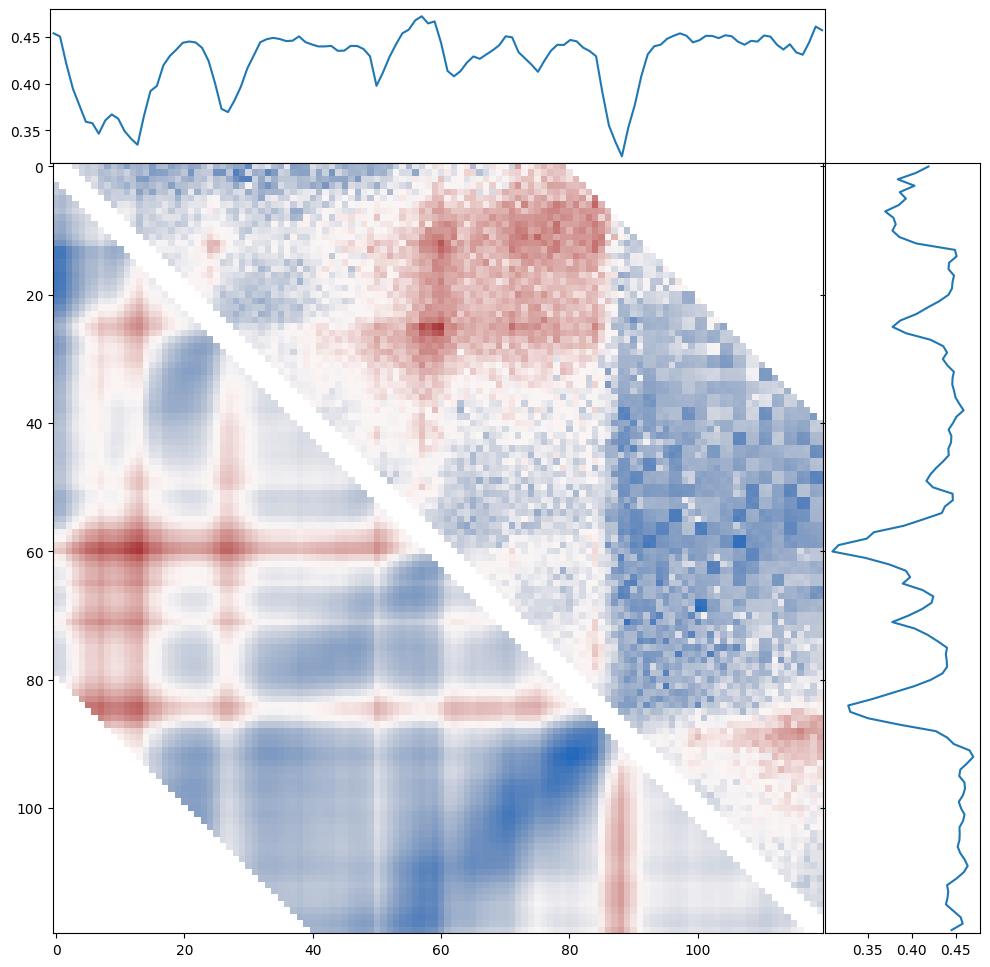

In [ ]:
util.plot_results(patch_mat[0], preds[0],
                (p_l[0], p_r[0], np.ones_like(p_l)),
                ignore_i=data.start_diag, ignore_i_off=data.stop_diag,
                cmap="vlag", scale=1)

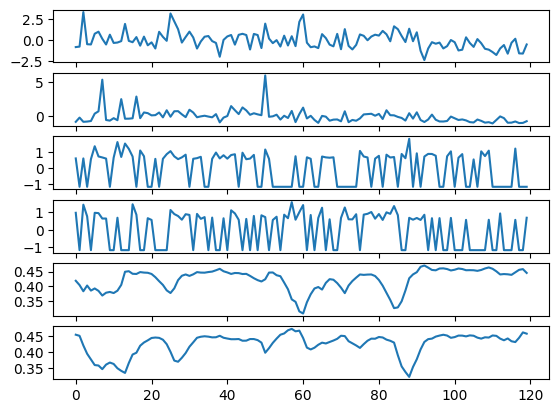

In [ ]:
fig, axes = plt.subplots(nrows=6)
for i, ax in enumerate(axes[:samples[1].shape[1]]):
    ax.plot(samples[1][0, i])
axes[4].plot(p_l[0])
axes[5].plot(p_r[0])

In [ ]:
tick_labels = np.array(["CTCF", "DNAse", "CTCF(left)", "CTCF(right)", "left", "right"])

In [ ]:
corrs_params = np.corrcoef(np.vstack([samples[1][0], p_l, p_r]))

In [ ]:
corrs_params.shape

(6, 6)

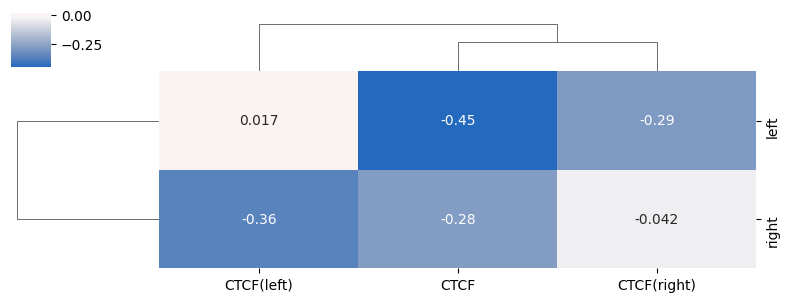

In [ ]:
seaborn.clustermap(corrs_params[[4, 5]][:,[0, 2, 3]],
                   yticklabels=tick_labels[[4,5]],
                   xticklabels=tick_labels[[0,2,3]],
                   cmap="vlag",
                   center=0,
                   annot=True,
                   figsize=(8,3))